CLIPProcessor:
- image_processor: CLIPImageProcessor {
  "crop_size": {
    "height": 336,
    "width": 336
  },
  "do_center_crop": true,
  "do_convert_rgb": true,
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.48145466,
    0.4578275,
    0.40821073
  ],
  "image_processor_type": "CLIPImageProcessor",
  "image_std": [
    0.26862954,
    0.26130258,
    0.27577711
  ],
  "resample": 3,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "shortest_edge": 336
  }
}

- tokenizer: CLIPTokenizerFast(name_or_path='openai/clip-vit-large-patch14-336', vocab_size=49408, model_max_length=77, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<|startoftext|>', 'eos_token': '<|endoftext|>', 'unk_token': '<|endoftext|>', 'pad_token': '<|endoftext|>'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	49406: AddedToken("<|startoftext|>", rstrip=False, lstrip=False, single_word=False, normalized=True

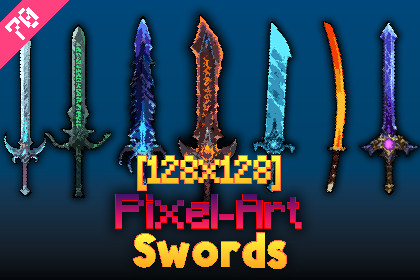

In [60]:
from transformers import CLIPVisionModel, CLIPImageProcessor, CLIPVisionConfig, CLIPProcessor
import requests

# 可参考：https://colab.research.google.com/drive/1pPHiwHUnM3zmTLtMcNL2zTu2M6FdKtRK?usp=sharing

img_path = "/data/gongoubo/VQA/LLaVA/llava/serve/examples/waterview.jpg"
# openai/clip-vit-large-patch14-336

model = CLIPVisionModel.from_pretrained("openai/clip-vit-large-patch14-336", cache_dir="/data/gongoubo/VQA/LLaVA//model_hub/")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-large-patch14-336")

print(processor)

# 读取图片
# from PIL import Image
# image = Image.open(img_path)
# print(image)

url = 'https://assetstorev1-prd-cdn.unity3d.com/key-image/256cb8a3-4984-4545-8175-2b64f603887e.jpg'
image = PIL.Image.open(requests.get(url, stream=True).raw)
image

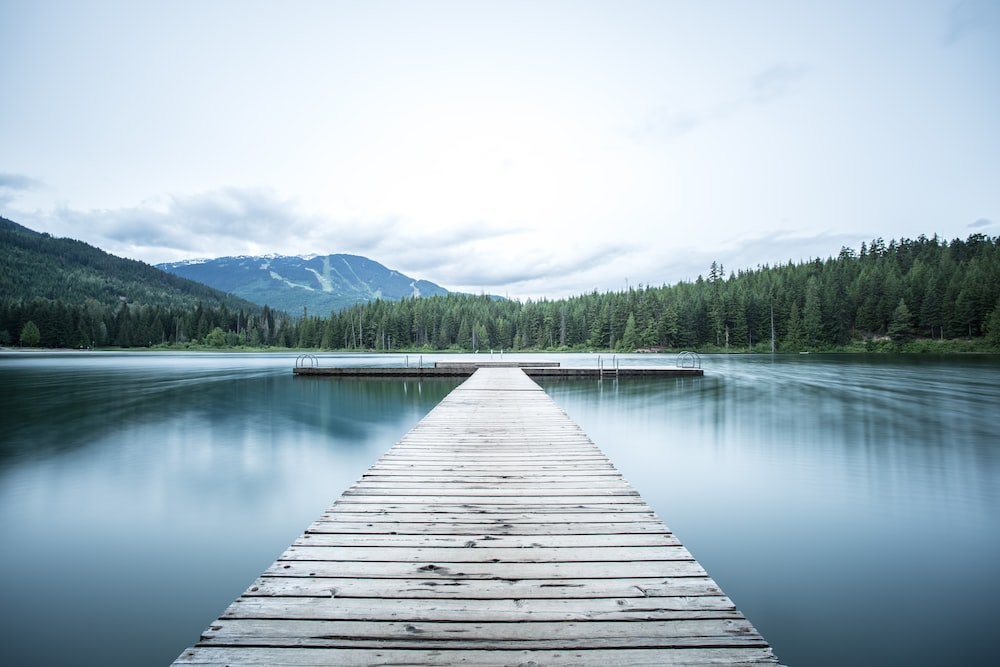

In [43]:
image

In [44]:
# 转换成RGB
image = image.convert("RGB")
image

import numpy as np
image_array = np.array(image)
image_array.shape
#  (height, width, channels)，其中 channels 的值取决于图像的模式（如 RGB 有 3 个通道，RGBA 有 4 个通道，灰度图像只有 1 个通道）。

(667, 1000, 3)

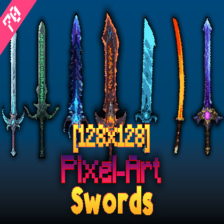

In [63]:
# 重新进行resize
import PIL
PILImageResampling = PIL.Image
resample = PILImageResampling.BILINEAR
width = 224
height = 224
reducing_gap = 1.0
resized_image = image.resize((width, height), resample=resample, reducing_gap=reducing_gap)
resized_image

In [45]:
image.size

(1000, 667)

In [61]:
import math
def resize_and_pad_image(image, target_resolution):
    """
    Resize and pad an image to a target resolution while maintaining aspect ratio.

    Args:
        image (PIL.Image.Image): The input image.
        target_resolution (tuple): The target resolution (width, height) of the image.

    Returns:
        PIL.Image.Image: The resized and padded image.
    """
    original_width, original_height = image.size
    target_width, target_height = target_resolution

    scale_w = target_width / original_width
    scale_h = target_height / original_height

    if scale_w < scale_h:
        new_width = target_width
        new_height = min(math.ceil(original_height * scale_w), target_height)
    else:
        new_height = target_height
        new_width = min(math.ceil(original_width * scale_h), target_width)

    # Resize the image
    resized_image = image.resize((new_width, new_height))

    new_image = Image.new('RGB', (target_width, target_height), (0, 0, 0))
    paste_x = (target_width - new_width) // 2
    paste_y = (target_height - new_height) // 2
    new_image.paste(resized_image, (paste_x, paste_y))

    return new_image

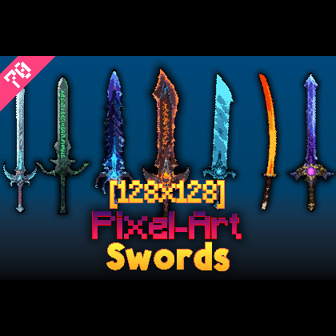

In [62]:
image2 = resize_and_pad_image(image, (336, 336))
image2

In [56]:
def divide_to_patches(image, patch_size):
    """
    Divides an image into patches of a specified size.

    Args:
        image (PIL.Image.Image): The input image.
        patch_size (int): The size of each patch.

    Returns:
        list: A list of PIL.Image.Image objects representing the patches.
    """
    patches = []
    width, height = image.size
    for i in range(0, height, patch_size):
        for j in range(0, width, patch_size):
            box = (j, i, j + patch_size, i + patch_size)
            patch = image.crop(box)
            patches.append(patch)

    return patches

patches = divide_to_patches(image2, 24)
print(len(patches))

196


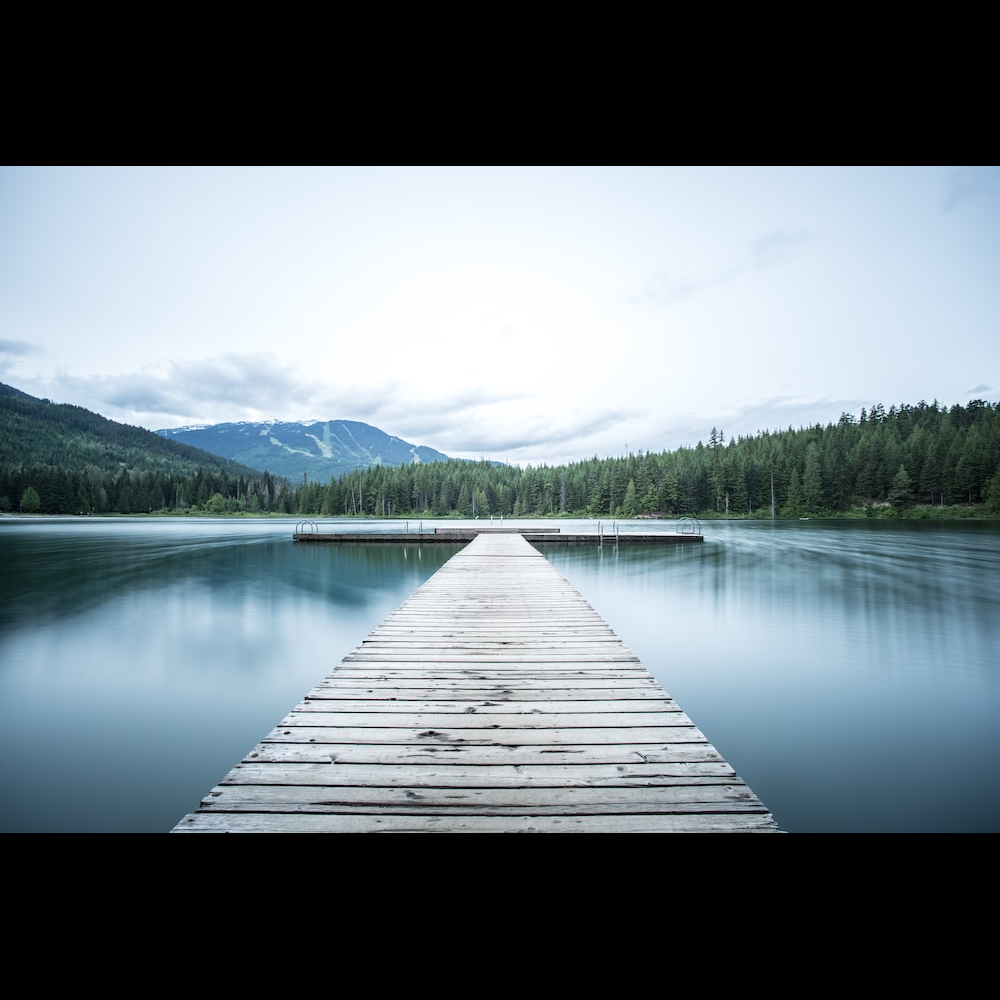

In [58]:
def expand2square(pil_img, background_color):
    width, height = pil_img.size
    if width == height:
        return pil_img
    elif width > height:
        result = Image.new(pil_img.mode, (width, width), background_color)
        result.paste(pil_img, (0, (width - height) // 2))
        return result
    else:
        result = Image.new(pil_img.mode, (height, height), background_color)
        result.paste(pil_img, ((height - width) // 2, 0))
        return result

image3 = expand2square(image, 0)
image3